# **MAAS Audio Filtering**

This notebook details the process of filtering wav audio files for usage in the MAAS project. The first five steps are an implementation of the process described by Salamon and Gómez [2]. The rest is inspired by the research done by Wang [3].

In [1]:
%load_ext autotime

time: 51.3 µs (started: 2024-11-07 01:52:36 -08:00)


In [2]:
# Imports
import numpy as np
from scipy import signal as sig
from scipy.io import wavfile as wav
import matplotlib.pyplot as plt
import tensorflow as tf

import tensorflow as tf
print("TensorFlow version:", tf.__version__)
print("GPU is available:", tf.config.list_physical_devices('GPU'))

2024-11-07 01:52:37.634788: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2024-11-07 01:52:37.643324: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1730973157.652532    2324 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1730973157.655128    2324 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-11-07 01:52:37.666017: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instr

TensorFlow version: 2.18.0
GPU is available: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
time: 2.14 s (started: 2024-11-07 01:52:36 -08:00)


In [3]:
# Read source wav file
sr, data = wav.read("./ui.wav")

time: 955 µs (started: 2024-11-07 01:52:39 -08:00)


## **Step 1.** Sinusoid Extraction

In [4]:
# 1.1. Equal Loudness Filtering
# Filter approximation by [1]

yule_b = tf.constant([0.05418656406430, -0.02911007808948, -0.00848709379851, -0.00851165645469,
                   -0.00834990904936, 0.02245293253339, -0.02596338512915, 0.01624864962975,
                   -0.00240879051584, 0.00674613682247, -0.00187763777362], dtype=tf.float32)
yule_a = tf.constant([1.0, -3.47845948550071, 6.36317777566148, -8.54751527471874, 9.47693607801280,
                   -8.81498681370155, 6.85401540936998, -4.39470996079559, 2.19611684890774,
                   -0.75104302451432, 0.13149317958808], dtype=tf.float32)
butter_b = tf.constant([0.98500175787242, -1.97000351574484, 0.98500175787242], dtype=tf.float32)
butter_a = tf.constant([1.0, -1.96977855582618, 0.97022847566350], dtype=tf.float32)

yule_b   = tf.reshape(yule_b, [1, int(yule_b.shape[0]), 1], name='yule_b')
butter_b = tf.reshape(butter_b, [int(butter_b.shape[0]), 1, 1], name='butter_b')
num = tf.squeeze(tf.nn.conv1d(yule_b, butter_b, 1, 'VALID'))

yule_a   = tf.reshape(yule_a, [1, int(yule_a.shape[0]), 1], name='yule_a')
butter_a = tf.reshape(butter_a, [int(butter_a.shape[0]), 1, 1], name='butter_a')
den = tf.squeeze(tf.nn.conv1d(yule_a, butter_a, 1, 'VALID'))

eq_data = sig.lfilter(num, den, data)
# Convierte los datos a un tensor de TensorFlow y colócalos en la GPU
with tf.device('/GPU:0'):
    eq_data = tf.convert_to_tensor(eq_data, dtype=tf.float32)

time: 434 ms (started: 2024-11-07 01:52:39 -08:00)


I0000 00:00:1730973159.168587    2324 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 5563 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060, pci bus id: 0000:01:00.0, compute capability: 8.9
I0000 00:00:1730973159.342518    2324 cuda_dnn.cc:529] Loaded cuDNN version 90300


In [8]:
# 1.2. Spectral Transform
# Apply Short-Time Fourier Transform

# Constants as calculated by [2]
# Values specific to 44.1 kHz, should be scalable to other sample rates
M = 2048
N = 8192
H = 128

# Define la ventana Hann en TensorFlow
window = tf.signal.hann_window(M, periodic=False, dtype=tf.float32)

def window_fn1(frame_length, dtype):
    return window

# Aplica la STFT
SFT = tf.signal.stft(window, frame_length=M, frame_step=H, fft_length=N, window_fn=window_fn1)
Sx = SFT.stft(eq_data)

abs_Sx = tf.abs(Sx)

AttributeError: 'tensorflow.python.framework.ops.EagerTensor' object has no attribute 'stft'

time: 39.8 ms (started: 2024-11-07 01:55:23 -08:00)


NameError: name 'SFT' is not defined

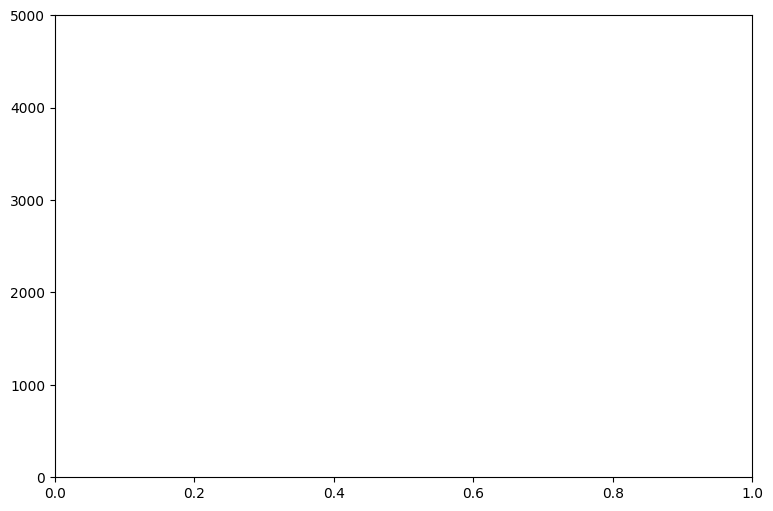

time: 340 ms (started: 2024-11-07 01:52:39 -08:00)


In [6]:
# Spectogram only for illustration purposes
fig1, ax1 = plt.subplots(figsize=(9., 6.))
ax1.set(ylim=(0, 5000))

im1 = ax1.imshow(abs_Sx, origin='lower', aspect='auto',
                 extent=SFT.extent(sr*np.size(data)), cmap='viridis')
fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [ ]:
# 1.3. Frequency/Amplitude Correction
# Identify local maxima of each time frame

peaks = sig.argrelmax(abs_Sx, axis=0, order=2)
pcp = max(abs(Sx[peaks[0], peaks[1]])) / 20

peak_ids = np.zeros(0, dtype=int)
for i in range(peaks[0].size):
  if abs(Sx[peaks[0][i], peaks[1][i]]) > pcp:
    peak_ids = np.append(peak_ids, i)

peaks_f = peaks[0][peak_ids]
peaks_t = peaks[1][peak_ids]

In [ ]:
# Graph only for illustration purposes
fig1, ax1 = plt.subplots(figsize=(9., 6.))
ax1.set(ylim=(0, 5000))

extents = SFT.extent(sr*data.size)
x_scale = data.size/Sx.shape[1]
y_scale = sr/N

im1 = ax1.imshow(abs_Sx, origin='lower', aspect='auto',
                 extent=extents, cmap='viridis')
ax1.plot(peaks_t * x_scale, peaks_f * y_scale, 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [ ]:
# Correct frequency and amplitude based on peaks' phase
# Done by computing instantaneous frequency (IF) and magnitude (Ai)

IF = np.zeros(peaks_f.size)
Ai = np.zeros(peaks_f.size)
koff = np.zeros(peaks_f.size)

for i in range(IF.size):
  k_offset = np.angle(Sx[peaks_f[i], peaks_t[i]]) - (2*np.pi*H*peaks_f[i]/N)
  if peaks_t[i] > 0: k_offset -= np.angle(Sx[peaks_f[i], peaks_t[i]-1])
  k_offset = k_offset%(2*np.pi)
  if k_offset > np.pi: k_offset -= 2*np.pi
  Wh = np.sinc(k_offset) / (2*(1 - k_offset**2))
  koff[i] = k_offset
  k_offset *= N/(2*np.pi*H)

  IF[i] = (peaks_f[i] + k_offset) * y_scale
  Ai[i] = abs(Sx[peaks_f[i], peaks_t[i]]) / (2*Wh)

In [ ]:
# Graph only for illustration purposes
fig1, ax1 = plt.subplots(figsize=(9., 6.))
ax1.set(ylim=(0, 5000))

im1 = ax1.imshow(abs_Sx, origin='lower', aspect='auto',
                 extent=extents, cmap='viridis')
ax1.plot(peaks_t * x_scale, peaks_f * y_scale, 'r.')
ax1.plot(peaks_t * x_scale, IF, 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

## **Step 2.** Salience Function Computation

In [ ]:
# Calculate number of peaks and highest peak per frame

peaks_per_f = np.zeros(Sx.shape[1], dtype=int)
max_peak = np.zeros(peaks_per_f.size, dtype=int)

for i in range(peaks_t.size):
  peaks_per_f[peaks_t[i]] += 1
  if IF[i] > max_peak[peaks_t[i]]:
    max_peak[peaks_t[i]] = i

In [ ]:
# Useful function definitions

# Bin: Computes (discrete) bin number of given frequency
def Bin(fi):
  return np.floor(120*np.log2(fi/55) + 1)

# Threshold: Whether or not a given peak is loud enough
# compared to highest peak in its frame
def Threshold(a, t, g):
  if np.log10(abs(Ai[max_peak[t]] / a)) < g:
    return 1
  else: return 0

# Weight: Assigns (cos^2) weight to bin if the given peak is a
# multiple of the bin's center frequency (harmonic)
def Weight(a, b, h, fi):
  d = abs(Bin(fi/h) - b)/10
  if d <= 1:
    return (a**(h-1)) * np.cos(np.pi*d/2)**2
  else: return 0

In [ ]:
# Constant values given by [2]
alpha = 0.8
beta = 1
gamma = 2
Nh = 20

# Useful peak indexing per frame
peaks_by_t = np.zeros((peaks_t.size, 2), dtype=int)
for i in range(peaks_t.size):
  peaks_by_t[i] = [peaks_t[i], i]
peaks_by_t = peaks_by_t[np.argsort(peaks_by_t[:,0])]

In [ ]:
# Computation of every bin's salience per frame

Sb = np.zeros((600, Sx.shape[1]))

index = 0
for l in range(Sb.shape[1]):
  for b in range(Sb.shape[0]):
    for n in range(peaks_per_f[l]):
      idx = index + n
      w = 0
      ea = Threshold(Ai[peaks_by_t[idx,1]], l, gamma)
      if ea == 0: continue
      ab = abs(Ai[peaks_by_t[idx,1]])**beta
      for h in range(Nh):
        w += Weight(alpha, b+1, h+1, IF[peaks_by_t[idx,1]])
      Sb[b, l] += w * ab
  index += peaks_per_f[l]

#for i in range(Sb.shape[0]):
  #for j in range(Sb.shape[1]):
    #if Sb[i, j] < 0.01: Sb[i, j] = 0

In [ ]:
# Figure only for illustration purposes
fig1, ax1 = plt.subplots(figsize=(9., 6.))

Sb2 = np.zeros(Sb.shape)
for i in range(Sb2.shape[0]):
  for j in range(Sb2.shape[1]):
    if Sb[i,j] != 0: Sb2[i,j] = np.log10(Sb[i,j])
    else: Sb2[i,j] = -2
    if Sb2[i,j] < -2: Sb2[i,j] = 0

new_extents = (extents[0], extents[1], extents[2], 600.0)
im1 = ax1.imshow(Sb2, origin='lower', aspect='auto',
                 extent=new_extents, cmap='viridis')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [ ]:
# Identify local maxima of each time frame

Speaks = sig.argrelmax(Sb, axis=0, order=5)
Speaks_arr = np.array([Speaks[0], Speaks[1]]).T
Speaks_arr = np.copy(Speaks_arr[np.argsort(Speaks_arr[:,1])])
pcp2 = max(abs(Sb[Speaks_arr[:,0], Speaks_arr[:,1]])) / 10

Speak_ids = np.zeros(0, dtype=int)
for i in range(Speaks_arr.shape[0]):
  if abs(Sb[Speaks_arr[i,0], Speaks_arr[i,1]]) > pcp2:
    Speak_ids = np.append(Speak_ids, i)

Speaks_b = Speaks_arr[Speak_ids, 0]
Speaks_t = Speaks_arr[Speak_ids, 1]

In [ ]:
# Graph only for illustration purposes
fig1, ax1 = plt.subplots(figsize=(9., 6.))

im1 = ax1.imshow(Sb, origin='lower', aspect='auto',
                 extent=new_extents, cmap='viridis')
ax1.plot(Speaks_t * x_scale, Speaks_b, 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

## **Step 3.** Peak Streaming

In [ ]:
# Calculate highest salience peaks per frame
# and filter low salience peaks

peak_Sb = Sb[Speaks_b, Speaks_t]
max_Speak = np.zeros(Sb.shape[1], dtype=int)
S_minus = np.zeros(0, dtype=int)

for i in range(peak_Sb.size):
  if peak_Sb[i] > peak_Sb[max_Speak[Speaks_t[i]]]:
    max_Speak[Speaks_t[i]] = i

for i in range(peak_Sb.size):
  max_id = max_Speak[Speaks_t[i]]
  if peak_Sb[i] < (peak_Sb[max_id] * 0.9):
    S_minus = np.append(S_minus, i)

In [ ]:
# Filter remaining peaks based on general frame salience

boolarr = np.ones(peak_Sb.size, dtype=bool)
for i in S_minus: boolarr[i] = False

N = peak_Sb.size - S_minus.size
s_mean = np.average(peak_Sb[boolarr])
s_dev = np.std(peak_Sb[boolarr])
min_S = s_mean - 0.9*s_dev

for a in range(peak_Sb.size):
  if boolarr[a] == 1 and peak_Sb[a] < min_S:
    S_minus = np.append(S_minus, a)
    boolarr[a] = 0

In [ ]:
# Graph only for illustration purposes
fig1, ax1 = plt.subplots(figsize=(9., 6.))

im1 = ax1.imshow(Sb, origin='lower', aspect='auto',
                 extent=new_extents, cmap='viridis')
ax1.plot(Speaks_t[boolarr] * x_scale, Speaks_b[boolarr], 'y.')

fig1.colorbar(im1)
fig1.tight_layout()

plt.show()

In [ ]:
S_plus = np.array(np.where(boolarr == 1))
while S_plus.size:
  it = np.argmax(peak_Sb[S_plus])
  S_plus = np.delete(S_plus, -1)

## **Step 4.** Pitch Contour Characterization

## **Step 5.** Melody Selection

In [ ]:
#with open("/content/sample_data/Sb.txt", "w") as txt:
#  for line in Sb:
#    for num in line:
#      txt.write(str(num) + ",")
#    txt.write("\n")

In [ ]:
#wav.write("/content/sample_data/newsong.wav", sr, eq_data)

## References

[1] https://replaygain.hydrogenaud.io/equal_loudness.html \\
[2] https://www.justinsalamon.com/uploads/4/3/9/4/4394963/salamongomezmelodytaslp2012.pdf \\
[3] https://www.ee.columbia.edu/~dpwe/papers/Wang03-shazam.pdf \\
[4] https://dafx.de/paper-archive/2006/papers/p_247.pdf \\
[5] https://www.db-thueringen.de/servlets/MCRFileNodeServlet/dbt_derivate_00038847/ilm1-2017000136.pdf